In [97]:
from ex2_utils import create_epanechnik_kernel, generate_responses_1, get_patch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import math
from ex1_utils import gausssmooth
from matplotlib.patches import Circle

In [124]:
def mean_shift(frame, size, position, eps=0.05):
    # Round to odd number
    kernel_size_x = int(math.ceil(size[0] / 2)) * 2 - 1
    kernel_size_y = int(math.ceil(size[1] / 2)) * 2 - 1

    # Caculate the derivatives of size of kernel
    x = np.arange(-(kernel_size_x // 2), (kernel_size_x // 2) + 1)
    y = np.arange(-(kernel_size_y // 2), (kernel_size_y // 2) + 1)
    xi_X, xi_Y = np.meshgrid(x, y)

    positions = [position]
    iter_count = 0
    while True:
        wi, _ = get_patch(frame, position, (kernel_size_x, kernel_size_y))

        # Calculate the changes in both x and y directions
        xk_X = np.sum(xi_X * wi) / np.sum(wi)
        xk_Y = np.sum(xi_Y * wi) / np.sum(wi)

        # Update the position accordingly
        position = (position[0] + xk_X, position[1] + xk_Y)
        positions.append(position)

        # Check if the algorithm converged
        if abs(xk_X) < eps and abs(xk_Y) < eps:
            break

        # Sanity check if the algorihtm does not converge
        if iter_count >= 500:
            break

        iter_count += 1

    position = tuple(map(int, np.floor(position)))
    positions.append(position)
    return position, iter_count, positions


In [125]:
responses = generate_responses_1()
size = (13, 13)
eps = 0.1
starting_position = (40, 40)
position, iters, positions = mean_shift(responses, size, starting_position, eps)
print(position, iters)

(51, 69) 27


In [166]:
def plot_image(responses, filename):
    plt.figure(facecolor="white", figsize=(12, 12), dpi=120)
    plt.imshow(responses, cmap='gray')
    plt.axis('off')
    plt.savefig("./img/" + filename, bbox_inches='tight')
    plt.show()

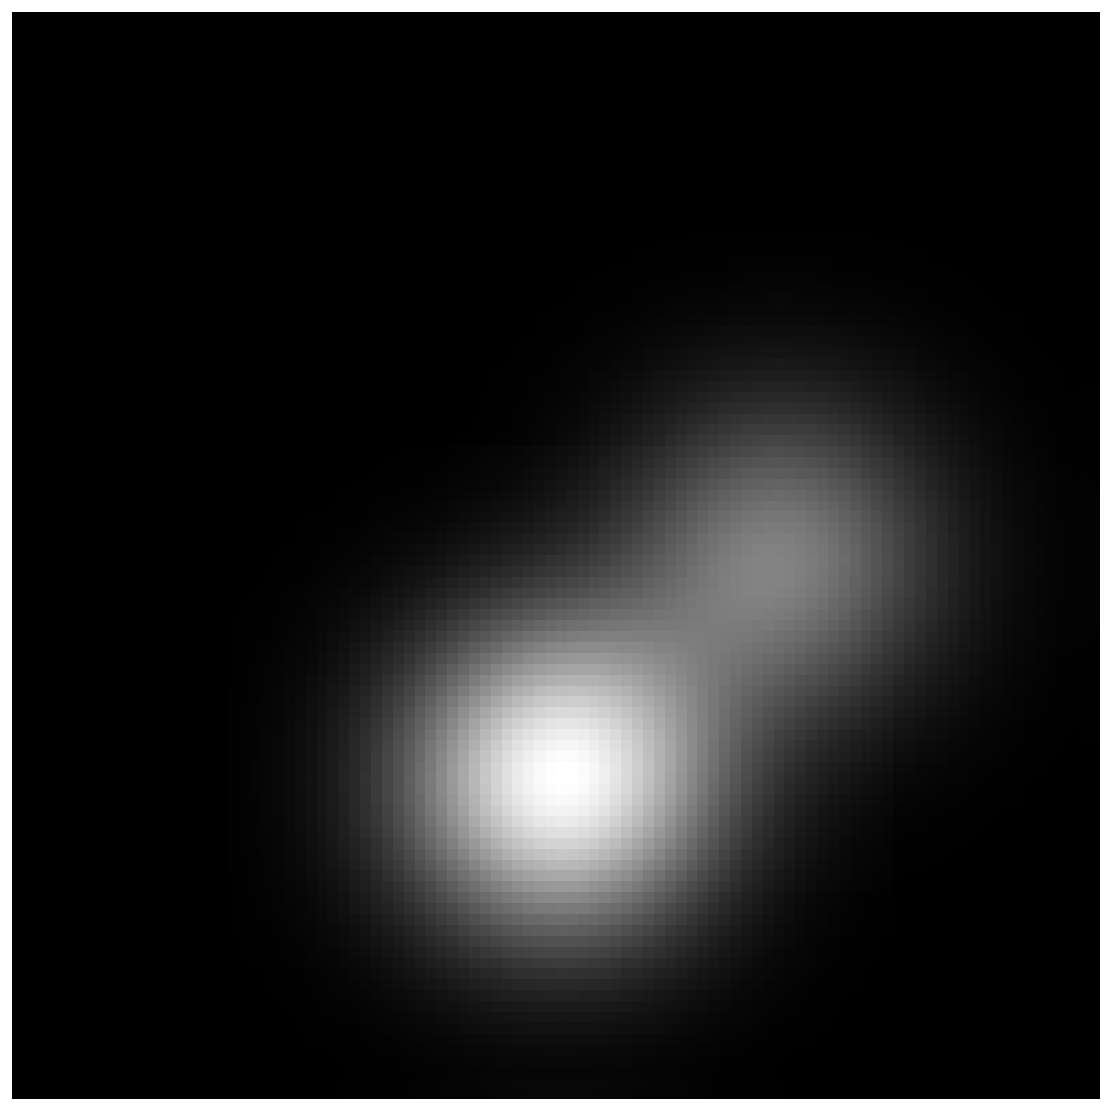

In [167]:
plot_image(responses, "responses-1.png")

In [141]:
def plot_prob_density_function(responses, filename):
    # create the x and y coordinate arrays (here we just use pixel indices)
    xx, yy = np.mgrid[0:responses.shape[0], 0:responses.shape[1]]

    # create the figure
    fig = plt.figure(facecolor="white", figsize=(12, 12), dpi=120)
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('$x$', fontsize=20)
    ax.set_ylabel('$y$', fontsize=20)
    ax.plot_surface(xx, yy, responses ,rstride=1, cstride=1, cmap=plt.cm.cool, linewidth=0)
    ax.view_init(30, 30)
    plt.savefig("./img/" + filename, bbox_inches='tight')
    plt.show()

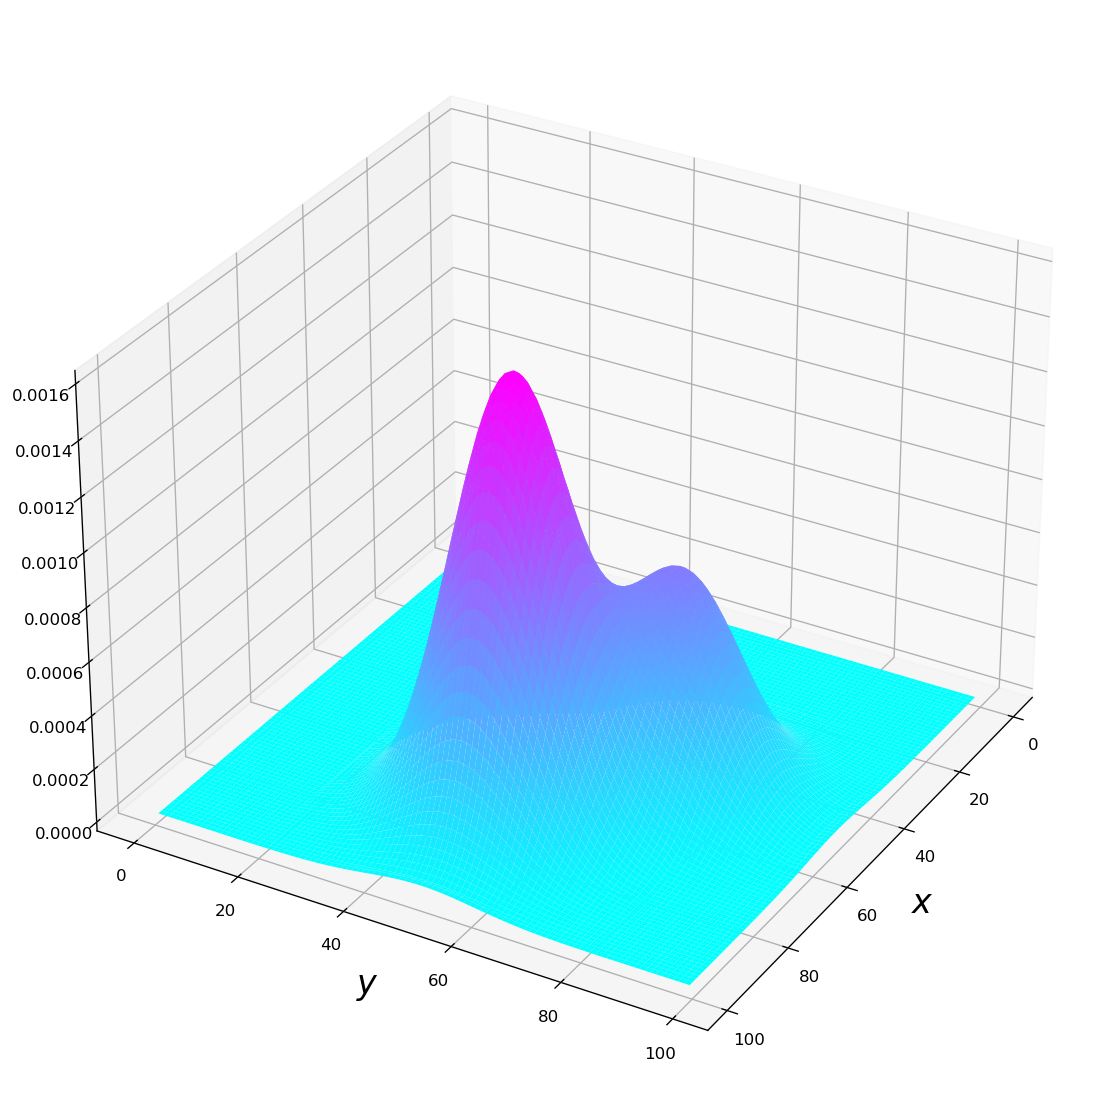

In [142]:
plot_prob_density_function(responses, "responses-1-function.png")

In [320]:
def generate_responses_2():
    responses = np.zeros((100, 100), dtype=np.float32)
    responses[30, 40] = 0.33
    responses[50, 60] = 0.66
    responses[70, 80] = 1
    return gausssmooth(responses, 10)

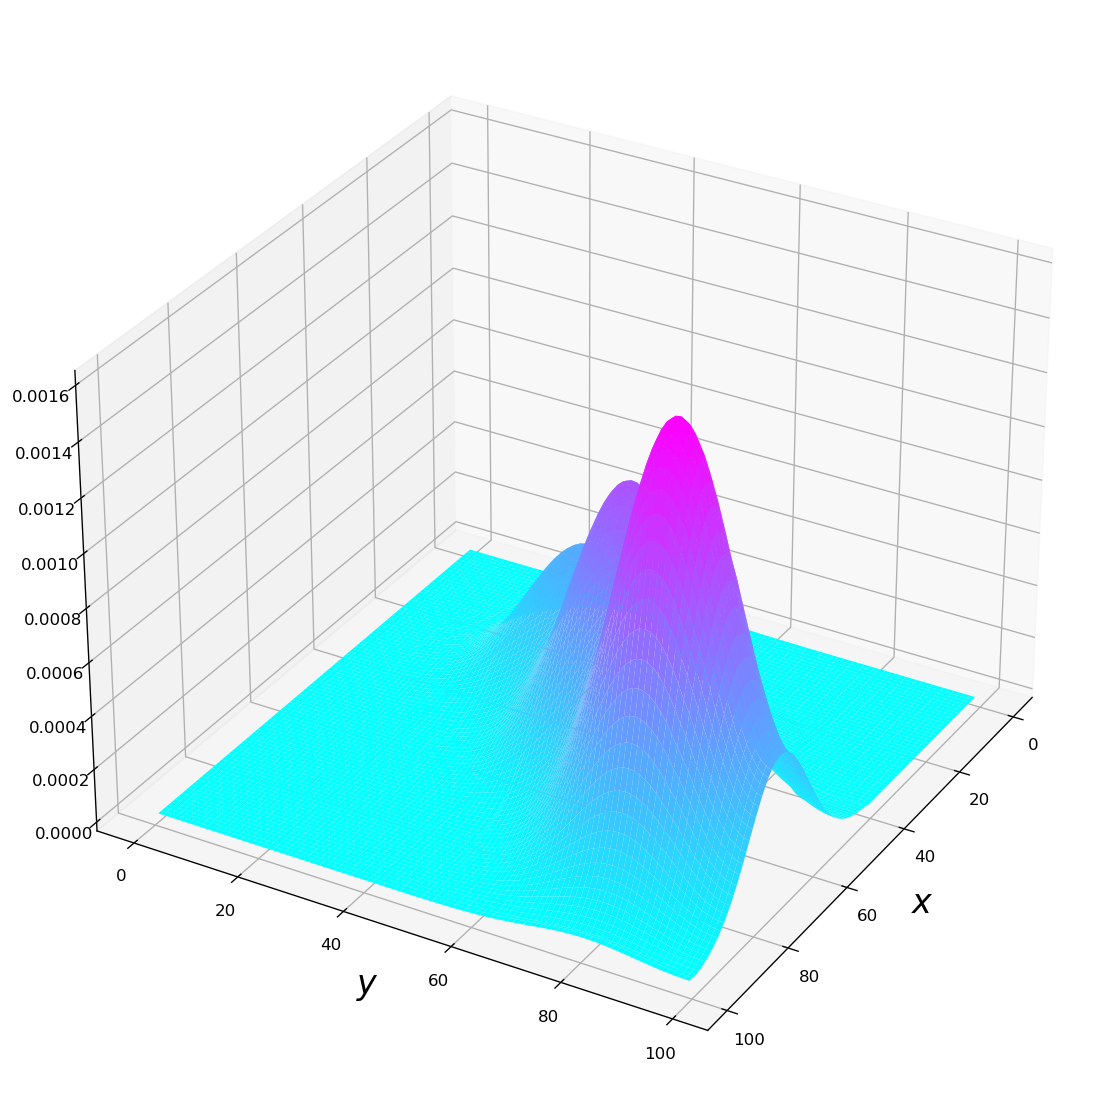

In [153]:
responses2 = generate_responses_2()
plot_prob_density_function(responses2, "responses-2-function.png")

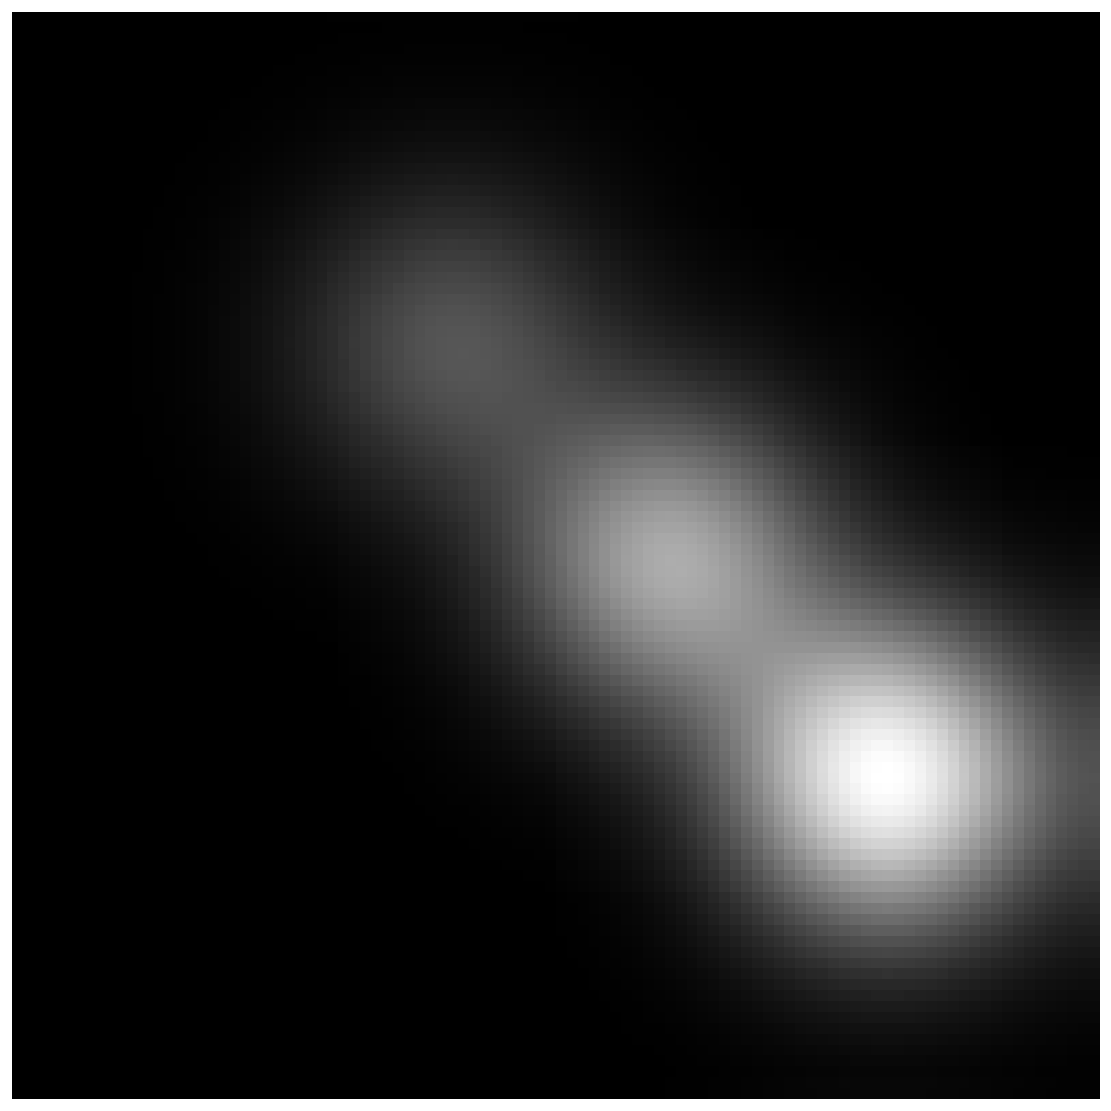

In [171]:
plot_image(responses2, "responses-2.png")

In [273]:
def plot_both(responses, filename):
    fig = plt.figure(facecolor="white", figsize=(20, 12), dpi=120)
    
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(responses, cmap='gray')
    ax1.axis('off')

    # create the x and y coordinate arrays (here we just use pixel indices)
    xx, yy = np.mgrid[0:responses.shape[0], 0:responses.shape[1]]

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.set_xlabel('$x$', fontsize=20)
    ax2.set_ylabel('$y$', fontsize=20)
    ax2.plot_surface(xx, yy, responses ,rstride=1, cstride=1, cmap=plt.cm.cool, linewidth=0)
    ax2.view_init(30, 30)

    plt.savefig("./img/" + filename, bbox_inches='tight')
    plt.show()

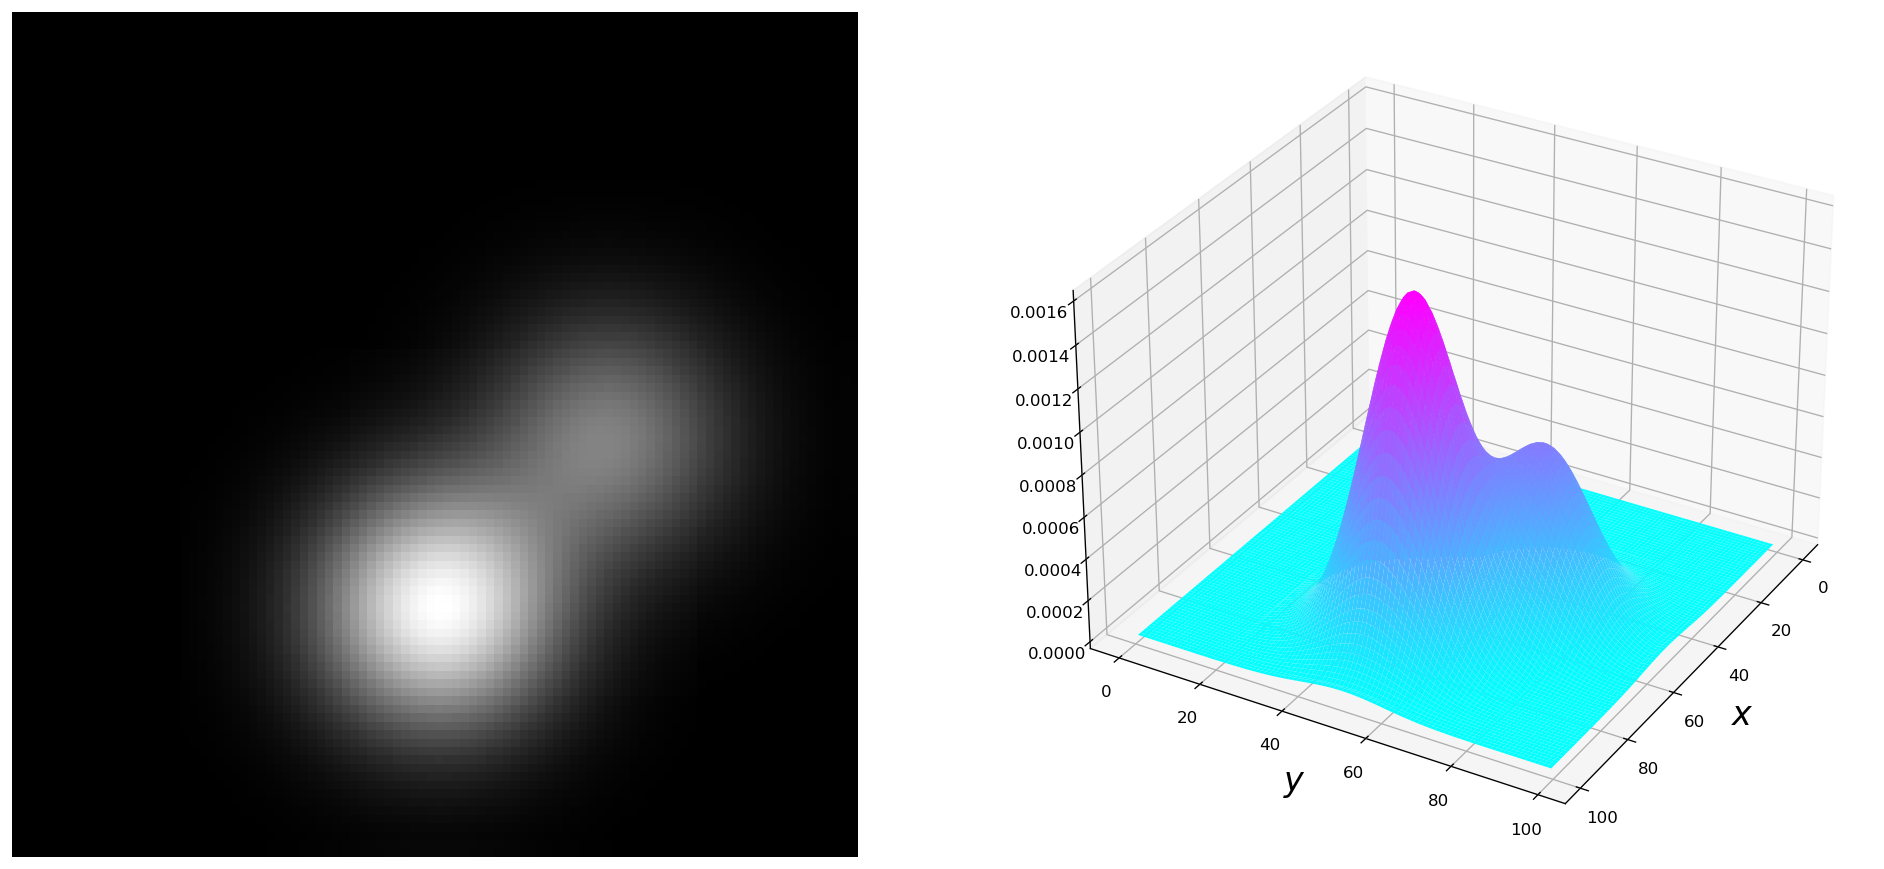

In [274]:
plot_both(responses, "both-1.png")

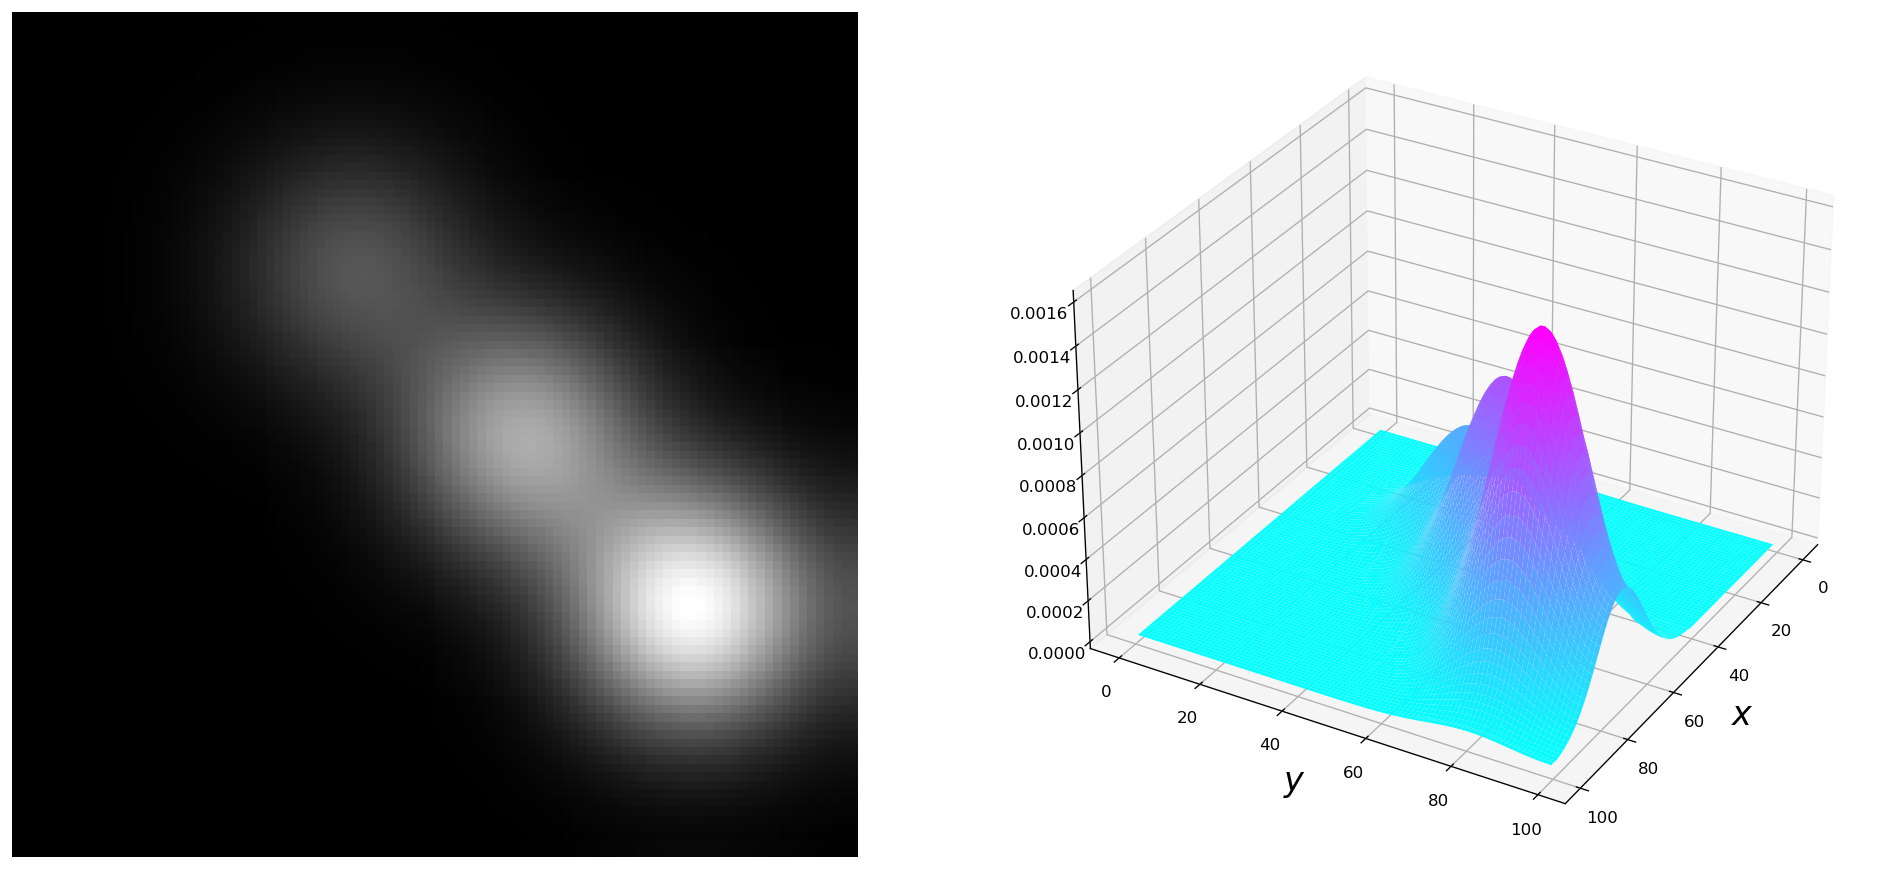

In [275]:
plot_both(responses2, "both-2.png")

In [289]:
def plot_image_with_track(responses, positions, filename):
    
    fig = plt.figure(facecolor="white", figsize=(6, 6), dpi=120)
    plt.imshow(responses, cmap='gray')
    plt.axis('off')

    x = [x for x, y in positions]
    y = [y for x, y in positions]
    plt.plot(x, y, marker='o', color='red')

    plt.savefig("./img/" + filename, bbox_inches='tight')
    plt.show()

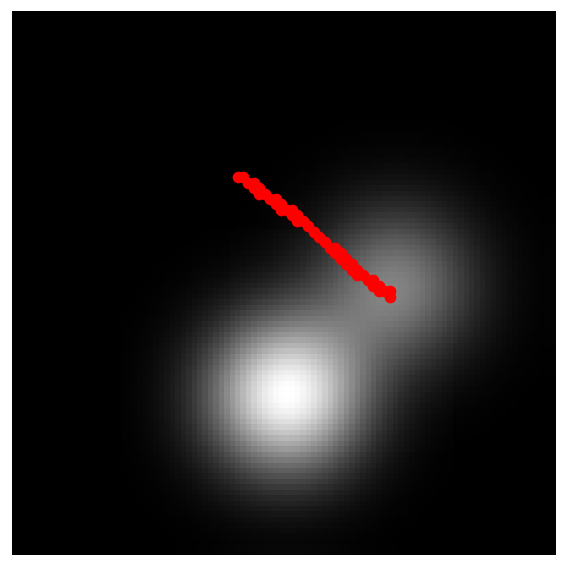

In [294]:
plot_image_with_track(responses, positions, "responses-1-with-track.png")

In [324]:
responses = generate_responses_1()
responses2 = generate_responses_2()

In [357]:
def try_different_parameters(responses, responses2):

    kernel_sizes = [(3, 3), (5, 5), (20, 20)]
    start_positions = [(50, 20), (45, 20),(40, 20)]

    fig, ((ax11, ax12), (ax21, ax22))= plt.subplots(2, 2, facecolor="white", figsize=(12, 12), dpi=160)
    ax11.imshow(responses, cmap='gray')
    ax11.axis('off')

    ax12.imshow(responses, cmap='gray')
    ax12.axis('off')

    ax21.imshow(responses2, cmap='gray')
    ax21.axis('off')

    color = ["#ff71ce", "#01cdfe", "#05ffa1", "#b967ff", "#fffb96"]
    for size, start, c in zip(kernel_sizes, start_positions, color):
        eps = 0.01
        ax11.add_patch(Circle(start, 1, color=c, alpha=0.4))
        ax11.add_patch(Circle(start, 2, color=c, alpha=0.3))
        position, iters, positions = mean_shift(responses, size, start, eps)
        ax11.add_patch(Circle(position, 1, color=c, alpha=0.6))
        x = [x for x, y in positions]
        y = [y for x, y in positions]
        label = "kernel size " + str(size)
        ax11.plot(x, y, color=c, markersize=5, label=label)

    start_positions = [(20, 40), (80, 80),(30, 70), (70, 30), (40, 40)]
    for start, c in zip(start_positions, color):
        eps = 0.01
        ax12.add_patch(Circle(start, 1, color=c, alpha=0.4))
        ax12.add_patch(Circle(start, 2, color=c, alpha=0.3))
        position, iters, positions = mean_shift(responses, (5, 5), start, eps)
        ax12.add_patch(Circle(position, 1, color=c, alpha=0.6))
        x = [x for x, y in positions]
        y = [y for x, y in positions]
        label = "starting position " + str(start)
        ax12.plot(x, y, color=c, markersize=5, label=label)

    
    # create the x and y coordinate arrays (here we just use pixel indices)
    xx, yy = np.mgrid[0:responses.shape[0], 0:responses.shape[1]]

    ax22.axis('off')
    ax22 = fig.add_subplot(2, 2, 4, projection='3d')
    ax22.set_xlabel('$x$', fontsize=20)
    ax22.set_ylabel('$y$', fontsize=20)
    ax22.plot_surface(xx, yy, responses ,rstride=1, cstride=1, cmap=plt.cm.cool, linewidth=10, zorder=1)
    ax22.view_init(30, 10)

    start_positions = [(90, 40), (80,70),(80, 80)]
    for start, c in zip(start_positions, color):
        eps = 0.01
        position, iters, positions = mean_shift(responses, (10, 10), start, eps)
        x = [x for x, y in positions]
        y = [y for x, y in positions]
        z = [responses[math.floor(x)][math.floor(y)] for x, y in positions]
        label = "kernel size " + str(size)
        ax22.plot(x, y, z, color="black", marker="o", markersize=2, label=label, zorder=10)

    
    start_positions = [(20, 40), (70, 90),(80, 50), (70, 30), (40, 40)]
    for start, c in zip(start_positions, color):
        eps = 0.01
        ax21.add_patch(Circle(start, 1, color=c, alpha=0.4))
        ax21.add_patch(Circle(start, 2, color=c, alpha=0.3))
        position, iters, positions = mean_shift(responses2, (5, 5), start, eps)
        ax21.add_patch(Circle(position, 1, color=c, alpha=0.6))
        x = [x for x, y in positions]
        y = [y for x, y in positions]
        label = "starting position " + str(start)
        ax21.plot(x, y, color=c, markersize=5, label=label)

    plt.subplots_adjust(wspace=0, hspace=0.05)
    ax11.legend(loc ="upper right")
    ax12.legend(loc ="upper left")
    ax21.legend(loc ="upper right")
    plt.savefig("./img/parameters-1.png", bbox_inches='tight')
    plt.show()

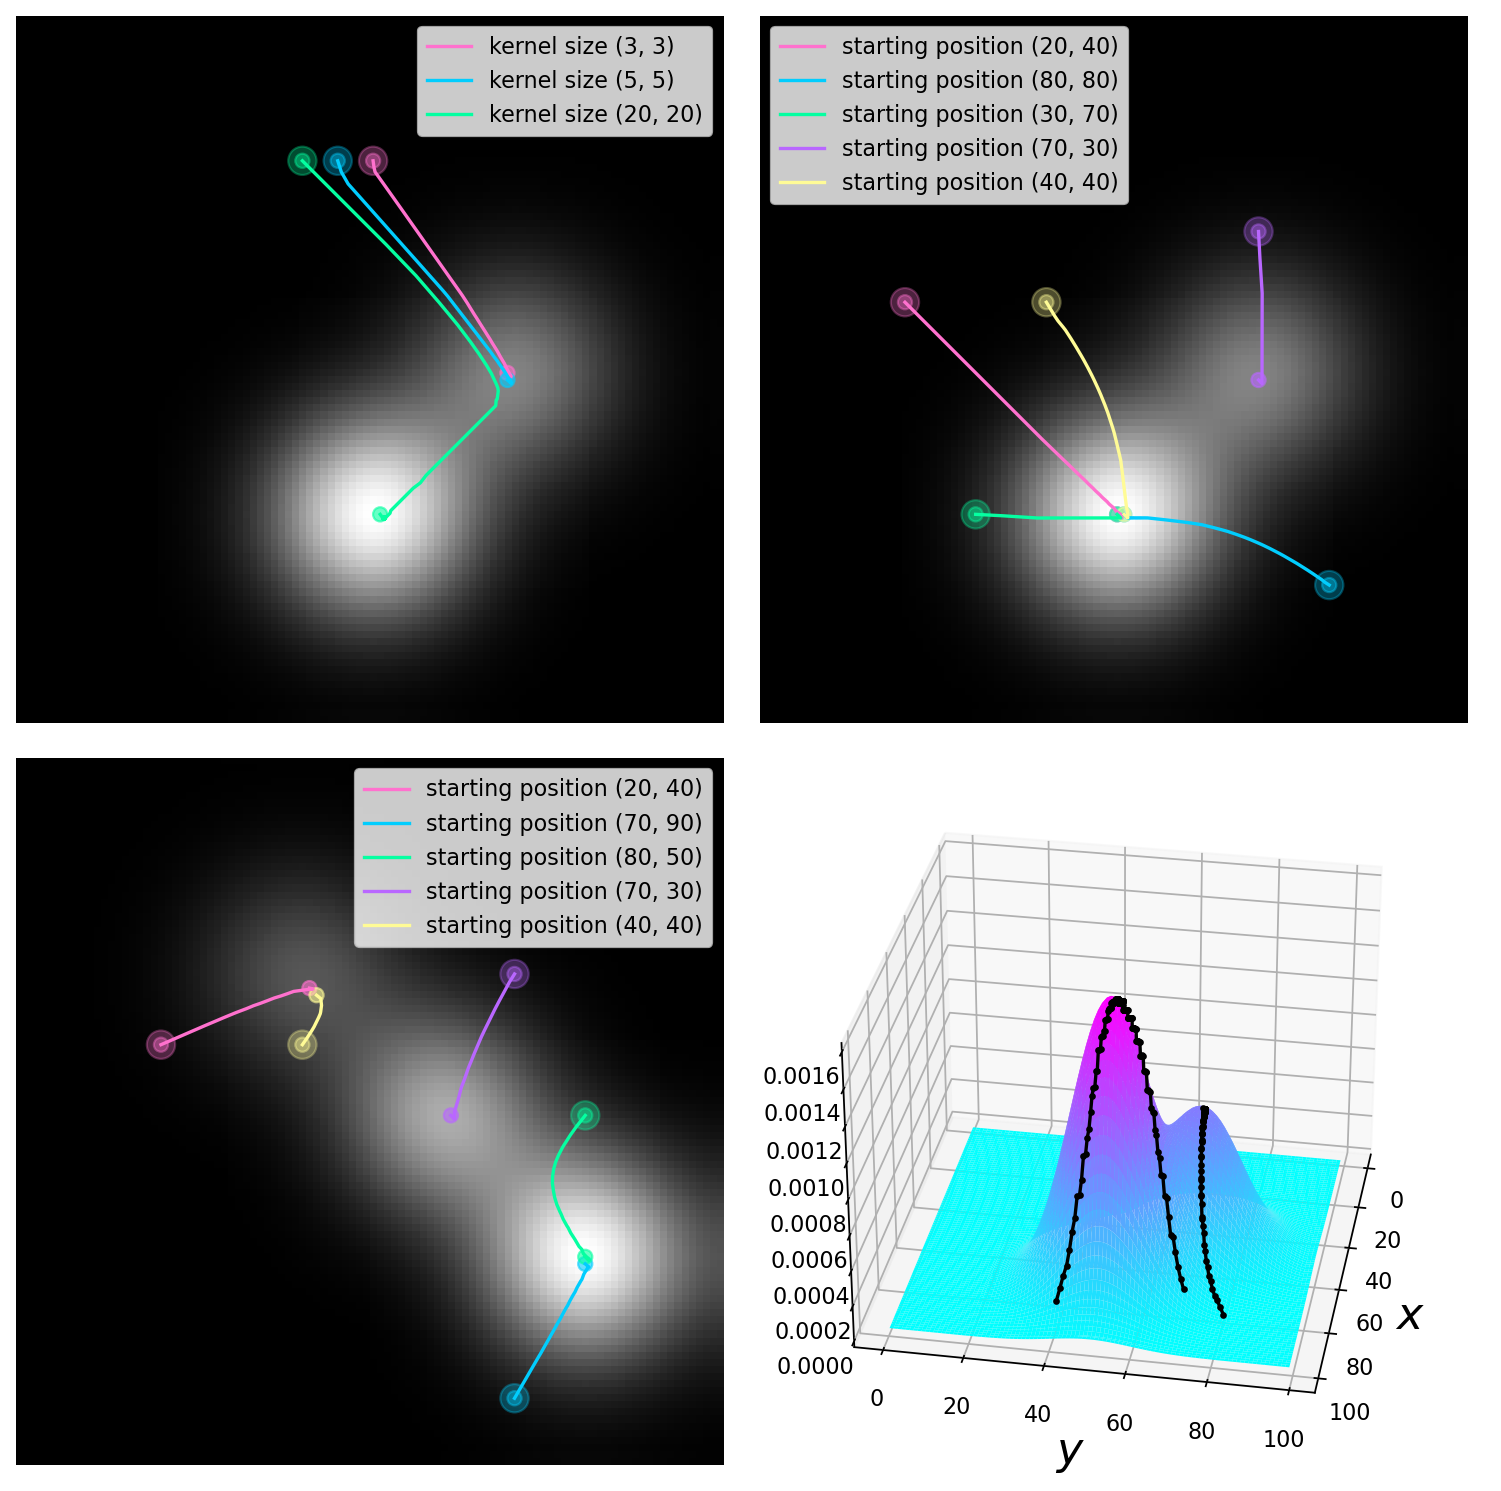

In [358]:
try_different_parameters(responses, responses2)

In [11]:
int(32.6)

32